In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
# Information for TIGRESS synthetic maps
# dust polarization maps at 353 GHz can be downloaded at https://lambda.gsfc.nasa.gov/simulation/tb_tigress_data.cfm
data_folder = '../data/allsky_maps/'

# 9 observer positions
observers = ['x0y0z0','x-256y0z0','x256y0z0',
             'x0y-256z0','x-256y-256z0','x256y-256z0',
             'x0y256z0','x-256y256z0','x256y256z0']

# 350 snapshots to process
itimes=np.arange(300,650,dtype=int)

In [4]:
# pandas and xarray are used to handle data
import pandas as pd
import xarray as xr
# seaborn is used for plotting
import seaborn as sns

In [5]:
# for |b|>30
bcut = 'b30'
with xr.open_dataset('../data/all_cls.nc') as dset:
    avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

# for |b|>60
# bcut = 'b30'
# with xr.open_dataset('../data/all_cls.b60.nc') as dset:
#     avg=dset.sel(leff=slice(80,120)).mean(dim='leff')

In [6]:
ratio=xr.Dataset()
ratio['EEBB'] = avg['EE']/avg['BB']
ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])

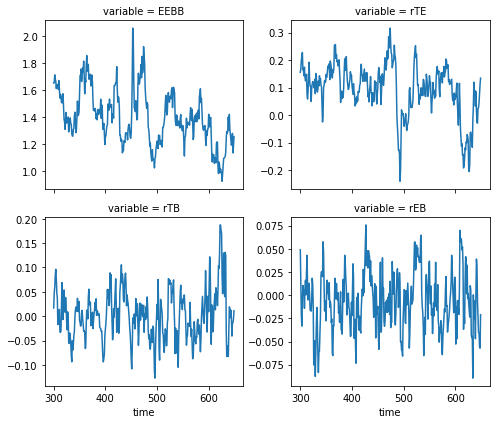

In [7]:
ratio.mean(dim='observer').to_array().plot(col='variable',sharey=False,col_wrap=2)

In [8]:
# convert to pandas dataframe to use seaborn pairplot
dlist=[]
for i,obs in enumerate(observers):
    df = ratio.sel(observer=i).to_array().to_pandas()
    ob=pd.Series(np.zeros_like(ratio.time)+i+1,index=ratio.time,name='observer',dtype=int)
    dlist.append(df.append(ob).T)

df=pd.concat(dlist,ignore_index=True)

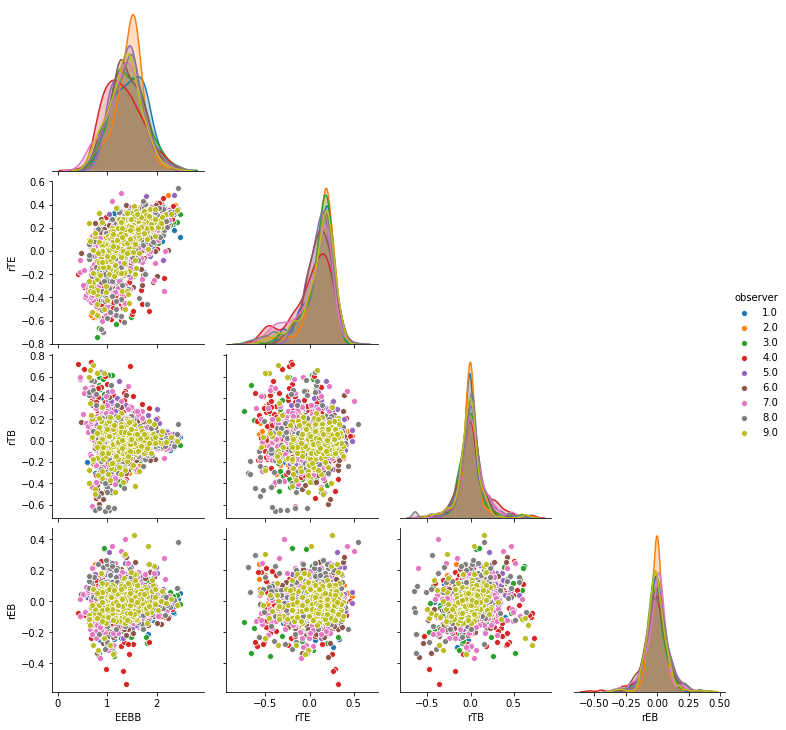

In [9]:
g = sns.pairplot(df.where((df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/all_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

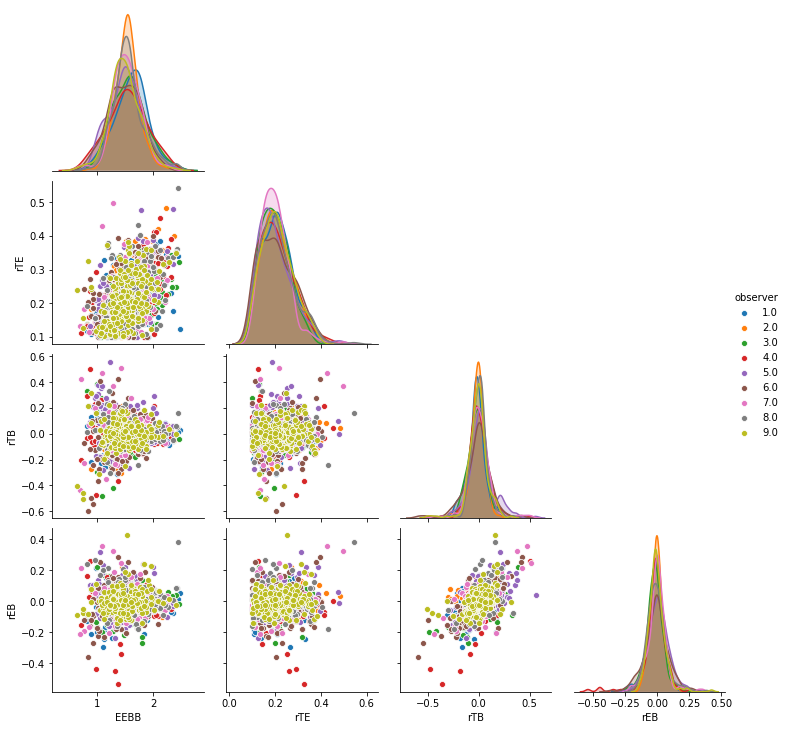

In [10]:
g=sns.pairplot(df.where((df.rTE>0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/rTEp01_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

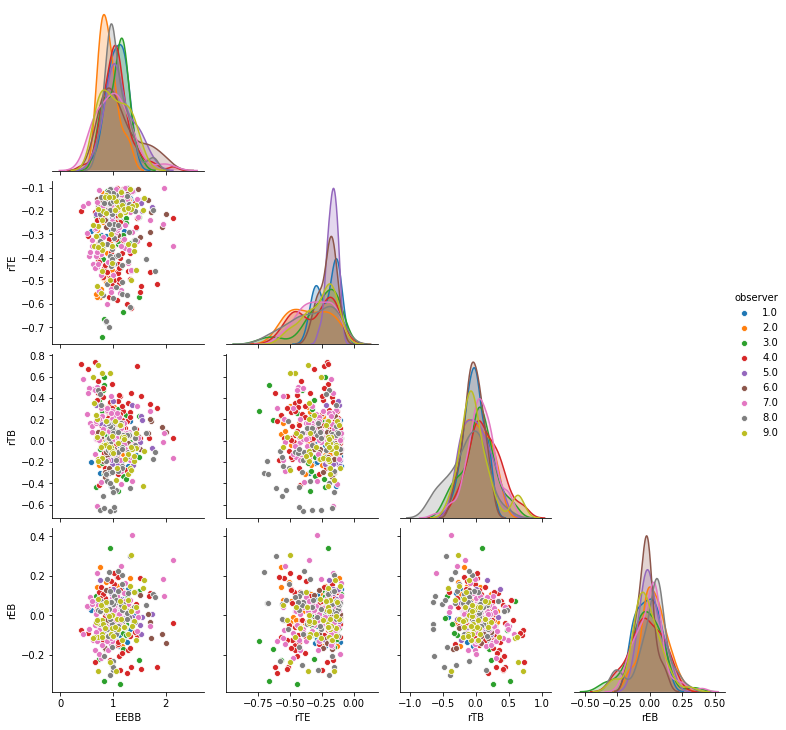

In [11]:
g=sns.pairplot(df.where((df.rTE<-0.1) & (df.EEBB<2.5)),hue='observer',dropna=True,corner=True)
g.savefig('../figures/rTEn01_ratios_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

# distribution from all observers with correlation coefficient

In [12]:
def pair_plot_with_corr(df_selected):
    g = sns.PairGrid(df_selected,diag_sharey=False,corner=True)
    g.map_lower(sns.scatterplot, s=15)
    g.map_diag(sns.distplot,kde=False)

    labels=[r'$EE/BB$',
            r'$rTE$',
            r'$rTB$',
            r'$rEB$'
           ]

    for ax,lab in zip(g.axes[1:,0],labels[1:]):
        ax.set_ylabel(lab)
    for ax,lab in zip(g.axes[-1,:],labels[:]):
        ax.set_xlabel(lab)
        
    corr = df_selected.corr()
    for i,xv in enumerate(g.x_vars):
        for j,yv in enumerate(g.y_vars[i+1:]):
            plt.sca(g.axes[j+i+1,i])
            plt.annotate(r'$\rho = {:.2f}$'.format(corr[xv][yv]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction')
            print(xv,yv,corr[xv][yv])
    for i,xv in enumerate(g.x_vars):
        plt.sca(g.axes[-1,i])
        if (xv == 'EEBB'): plt.xlim(0,3)
        elif (xv == 'rTE'): plt.xlim(-0.55,0.55)
        elif (xv == 'rTB'): plt.xlim(-0.55,0.55)
        elif (xv == 'rEB'): plt.xlim(-0.55,0.55)
    for i,yv in enumerate(g.y_vars[1:]):
        plt.sca(g.axes[i+1,0])
        if (yv == 'EEBB'): plt.ylim(0,3)
        elif (yv == 'rTE'): plt.ylim(-0.55,0.55)
        elif (yv == 'rTB'): plt.ylim(-0.55,0.55)
        elif (yv == 'rEB'): plt.ylim(-0.55,0.55)
    return g

EEBB rTE 0.5656994089946147
EEBB rTB -0.06604475280432204
EEBB rEB 0.0484571314136656
rTE rTB -0.06266199327675549
rTE rEB 0.030645788819743433
rTB rEB 0.22784150157265295


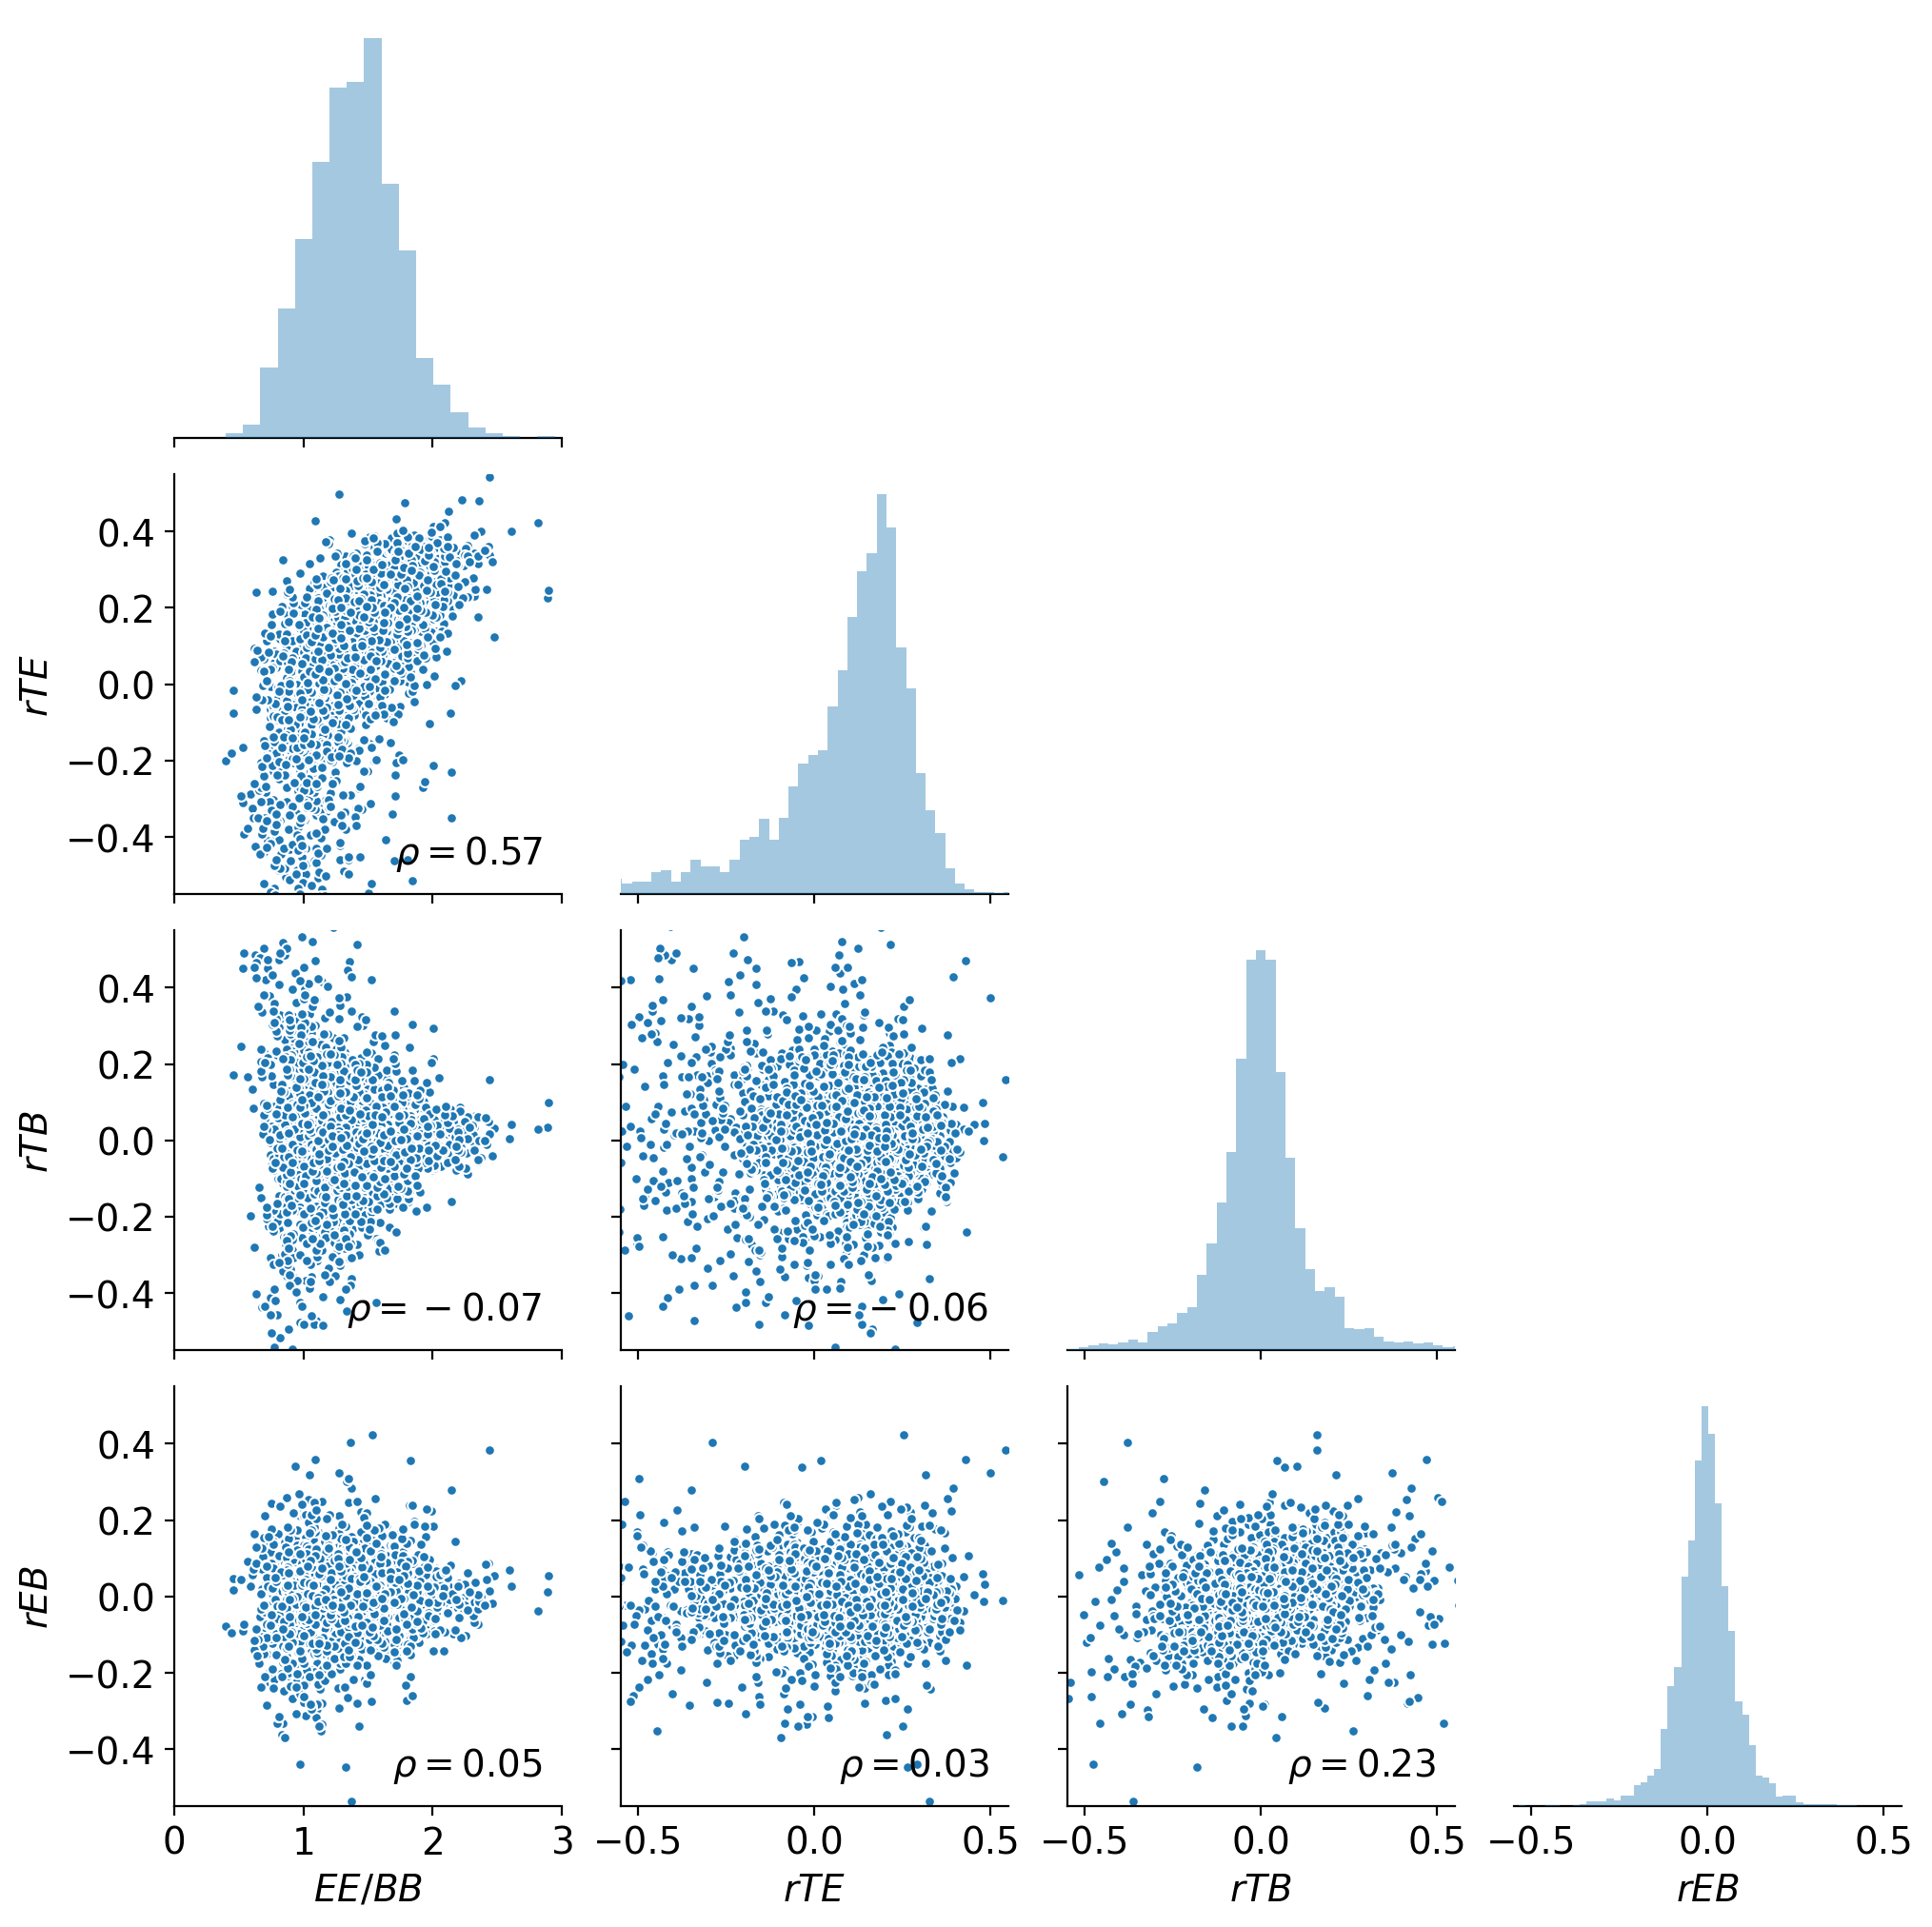

In [13]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']]
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/all_corr_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTE>0.1: rTB and rEB are correlated

EEBB rTE 0.45433932778323016
EEBB rTB 0.02786124795833873
EEBB rEB 0.045295832911295686
rTE rTB 0.04155453341290527
rTE rEB 0.0520965787075865
rTB rEB 0.5398367611469105


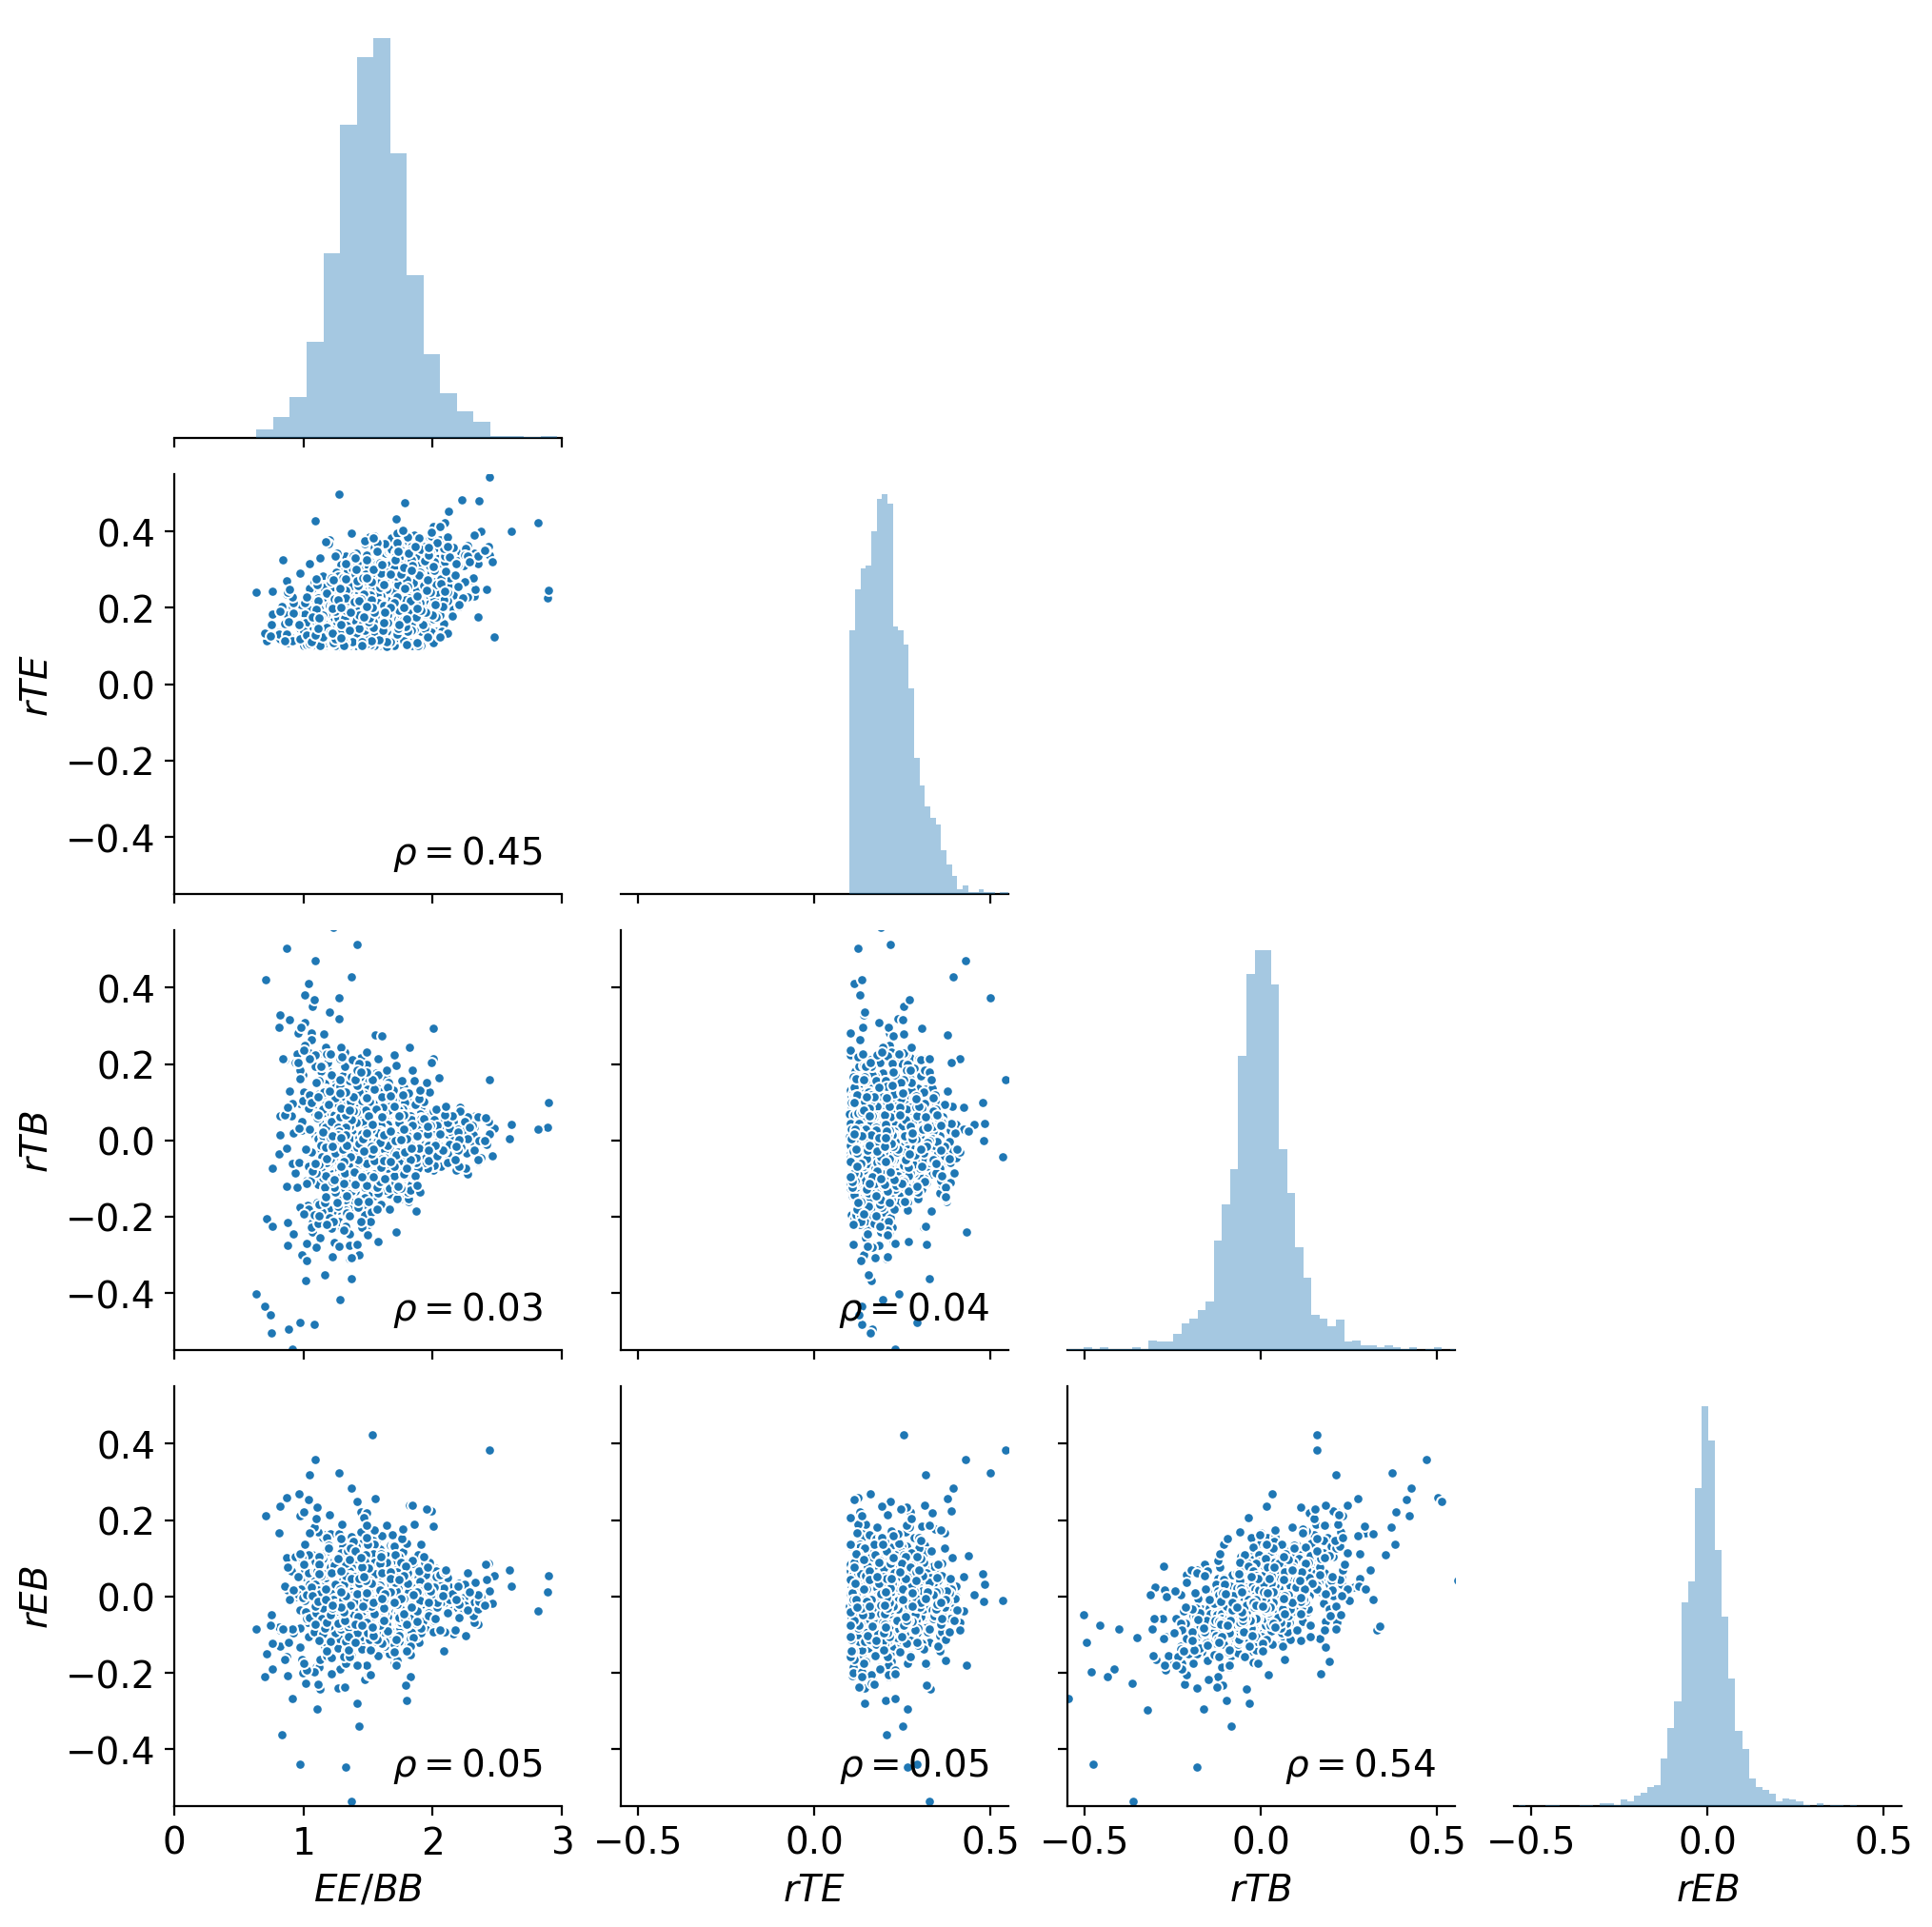

In [14]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTE>0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTEp01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTE<-0.1: rTB and rEB are anti-correlated

EEBB rTE 0.10478339217233693
EEBB rTB -0.12038003913346984
EEBB rEB 0.0970912020807875
rTE rTB -0.05907299057658472
rTE rEB 0.06034820483409119
rTB rEB -0.29076769100197103


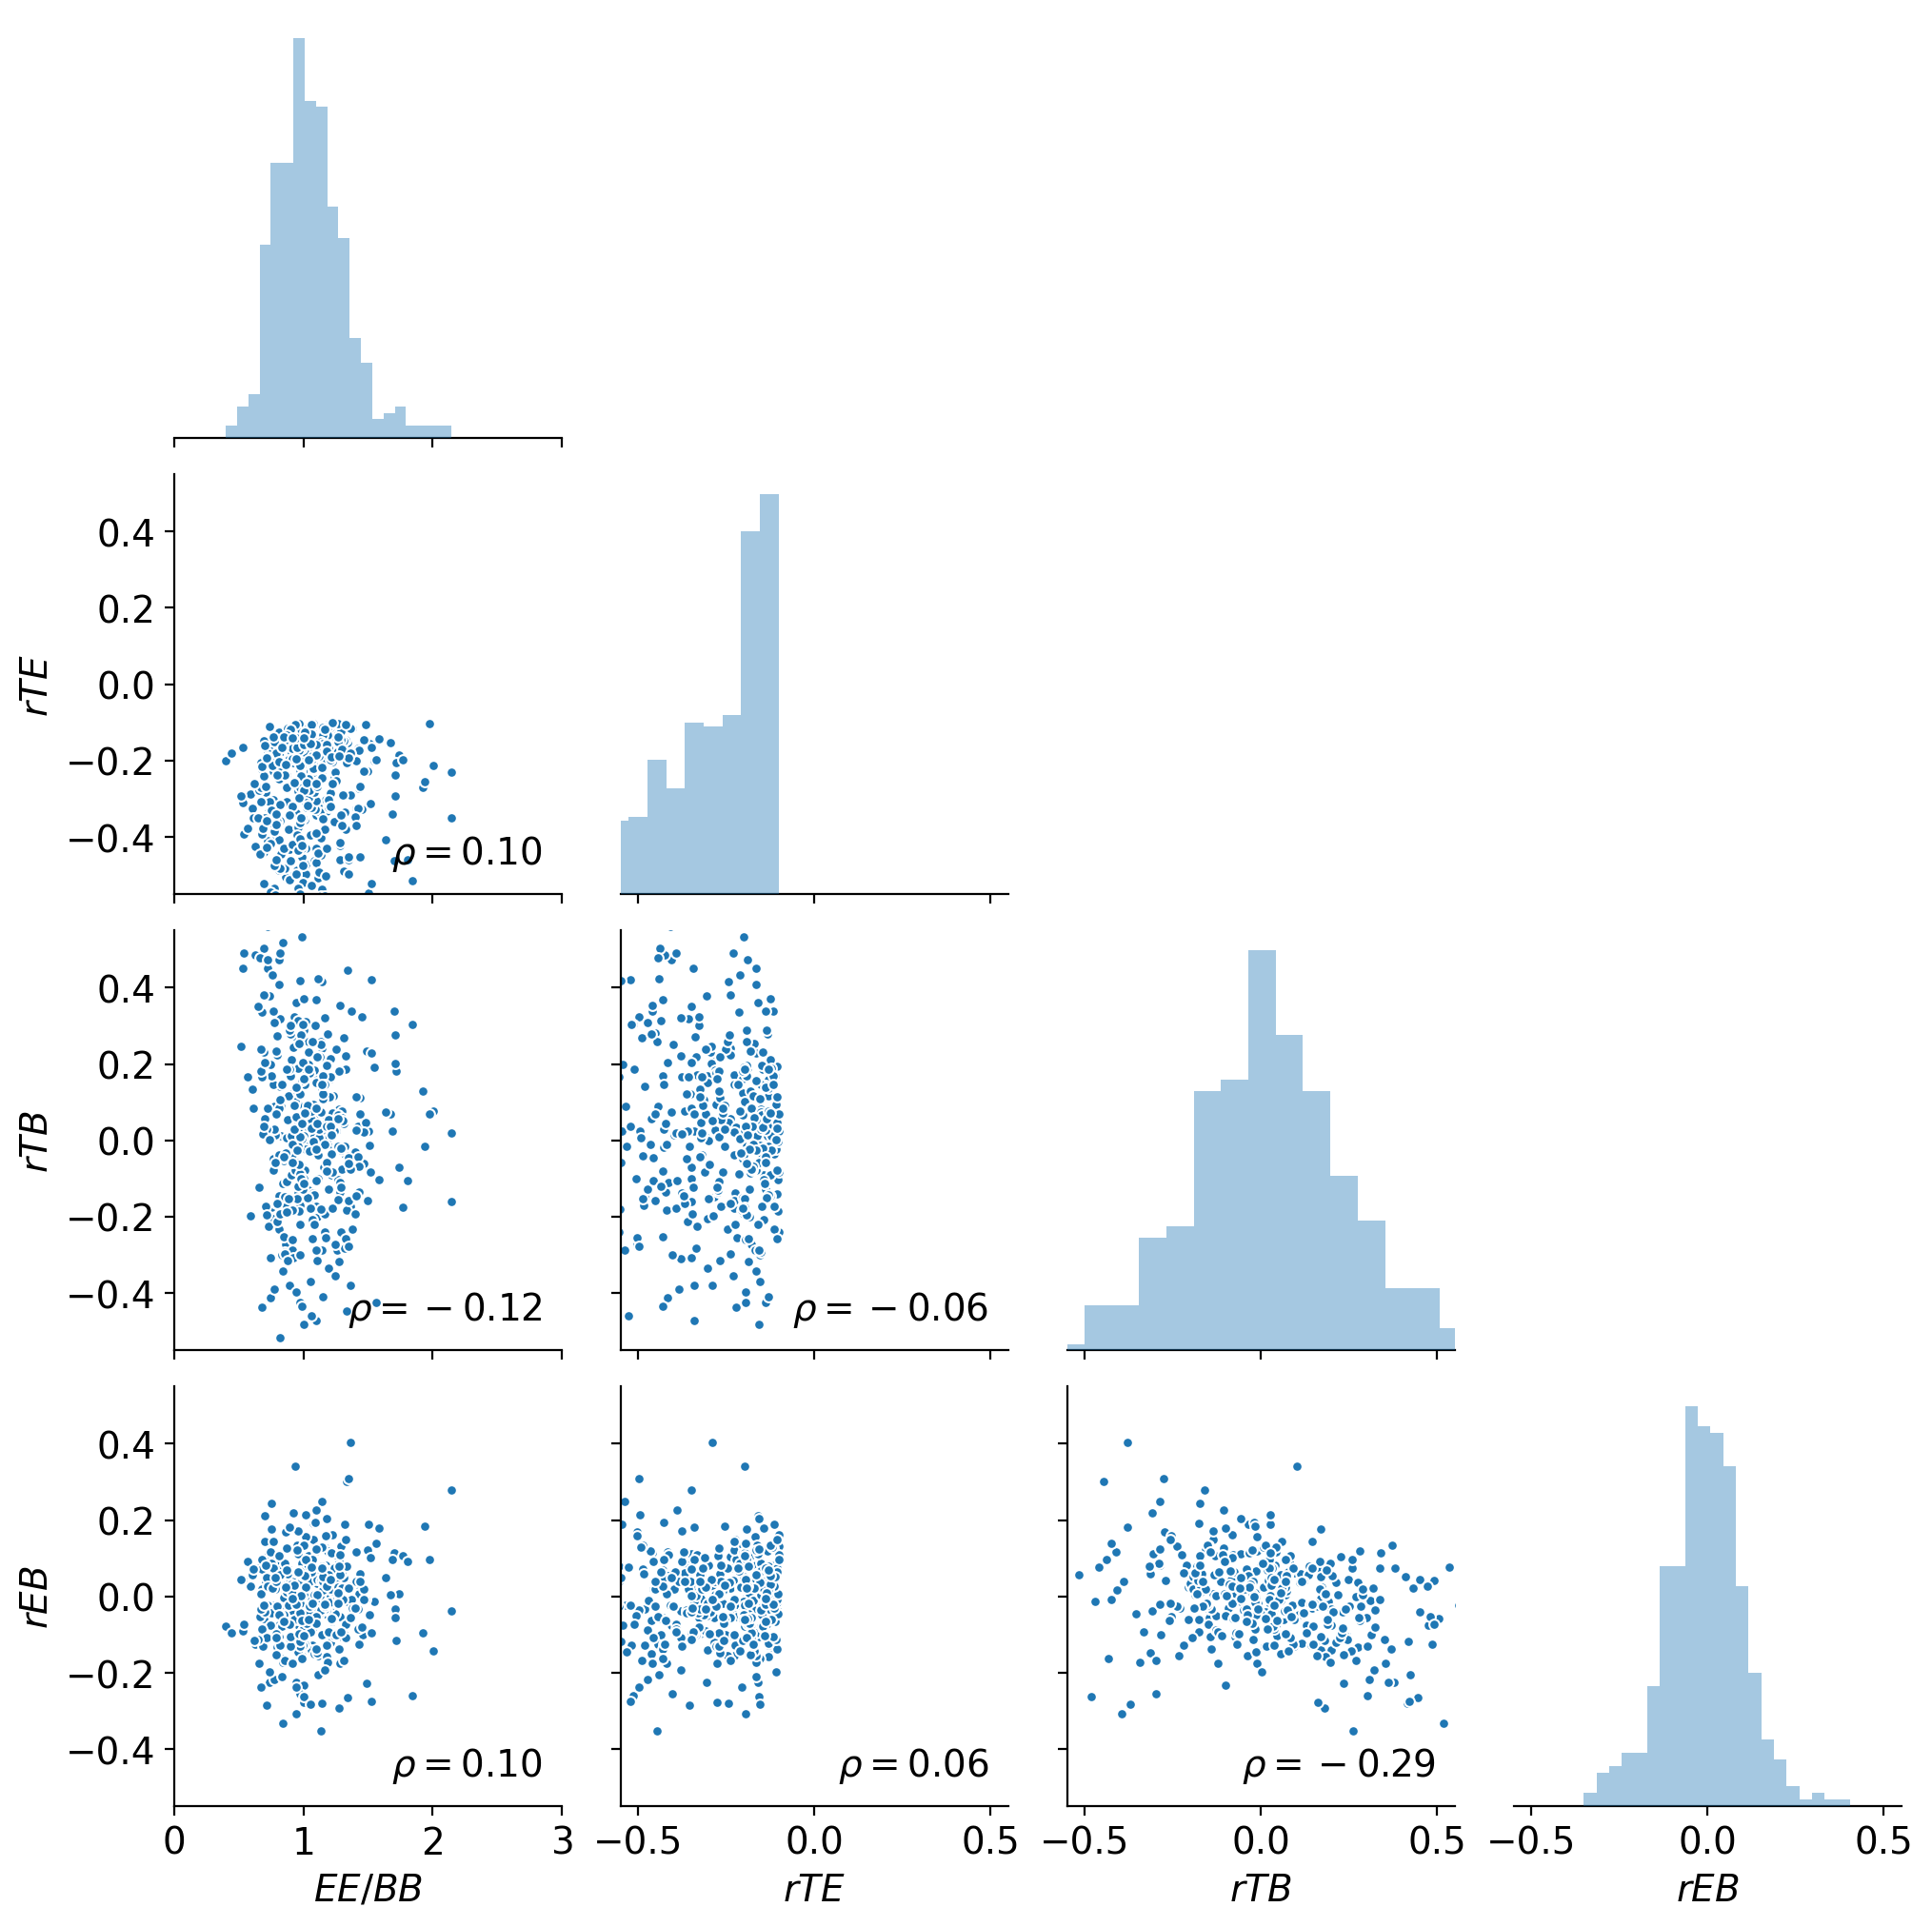

In [15]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTE<-0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTEn01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTB>0.1: rTE and rEB are correlated

EEBB rTE 0.4585778851184807
EEBB rTB -0.44945891692721174
EEBB rEB 0.16377751037332894
rTE rTB -0.3156733671381702
rTE rEB 0.5270300442277476
rTB rEB -0.10350686981068713


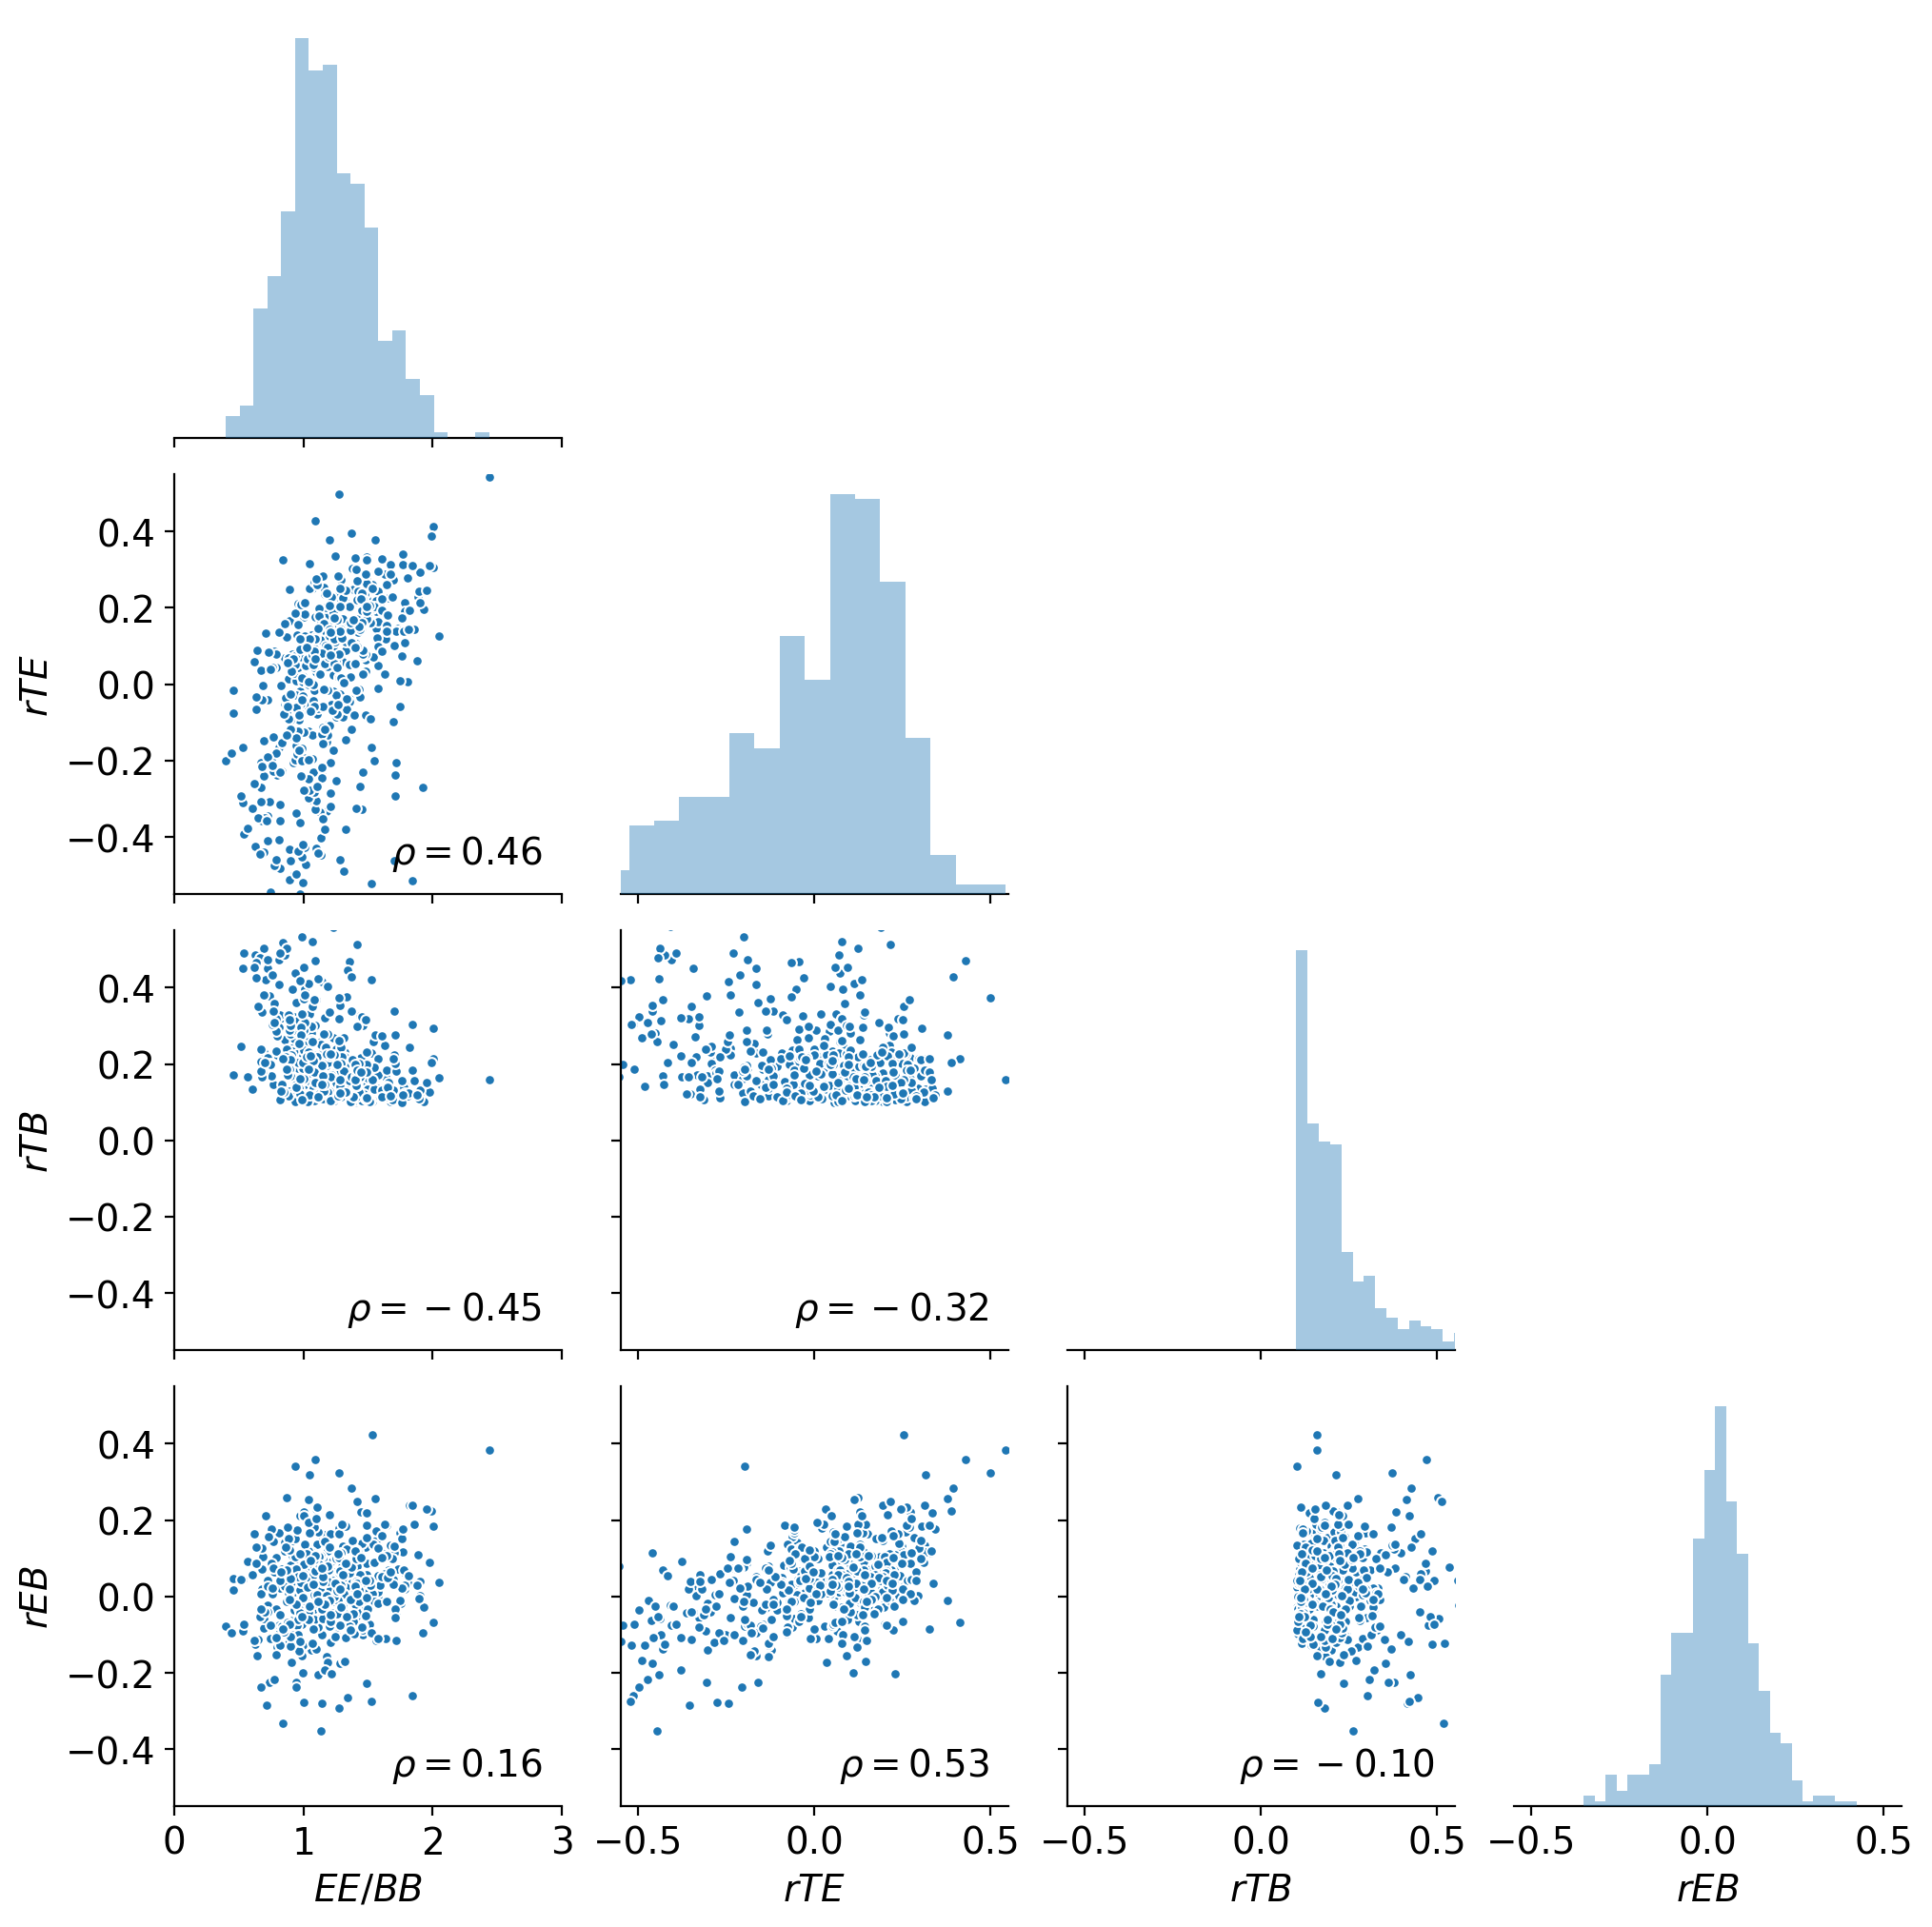

In [16]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTB>0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTBp01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)

## rTB<-0.1: rTE and rEB are anti-correlated

EEBB rTE 0.46837944635982504
EEBB rTB 0.36917142377416595
EEBB rEB 0.010752362759050123
rTE rTB 0.26008977548697515
rTE rEB -0.38728313115266183
rTB rEB 0.14271111519795684


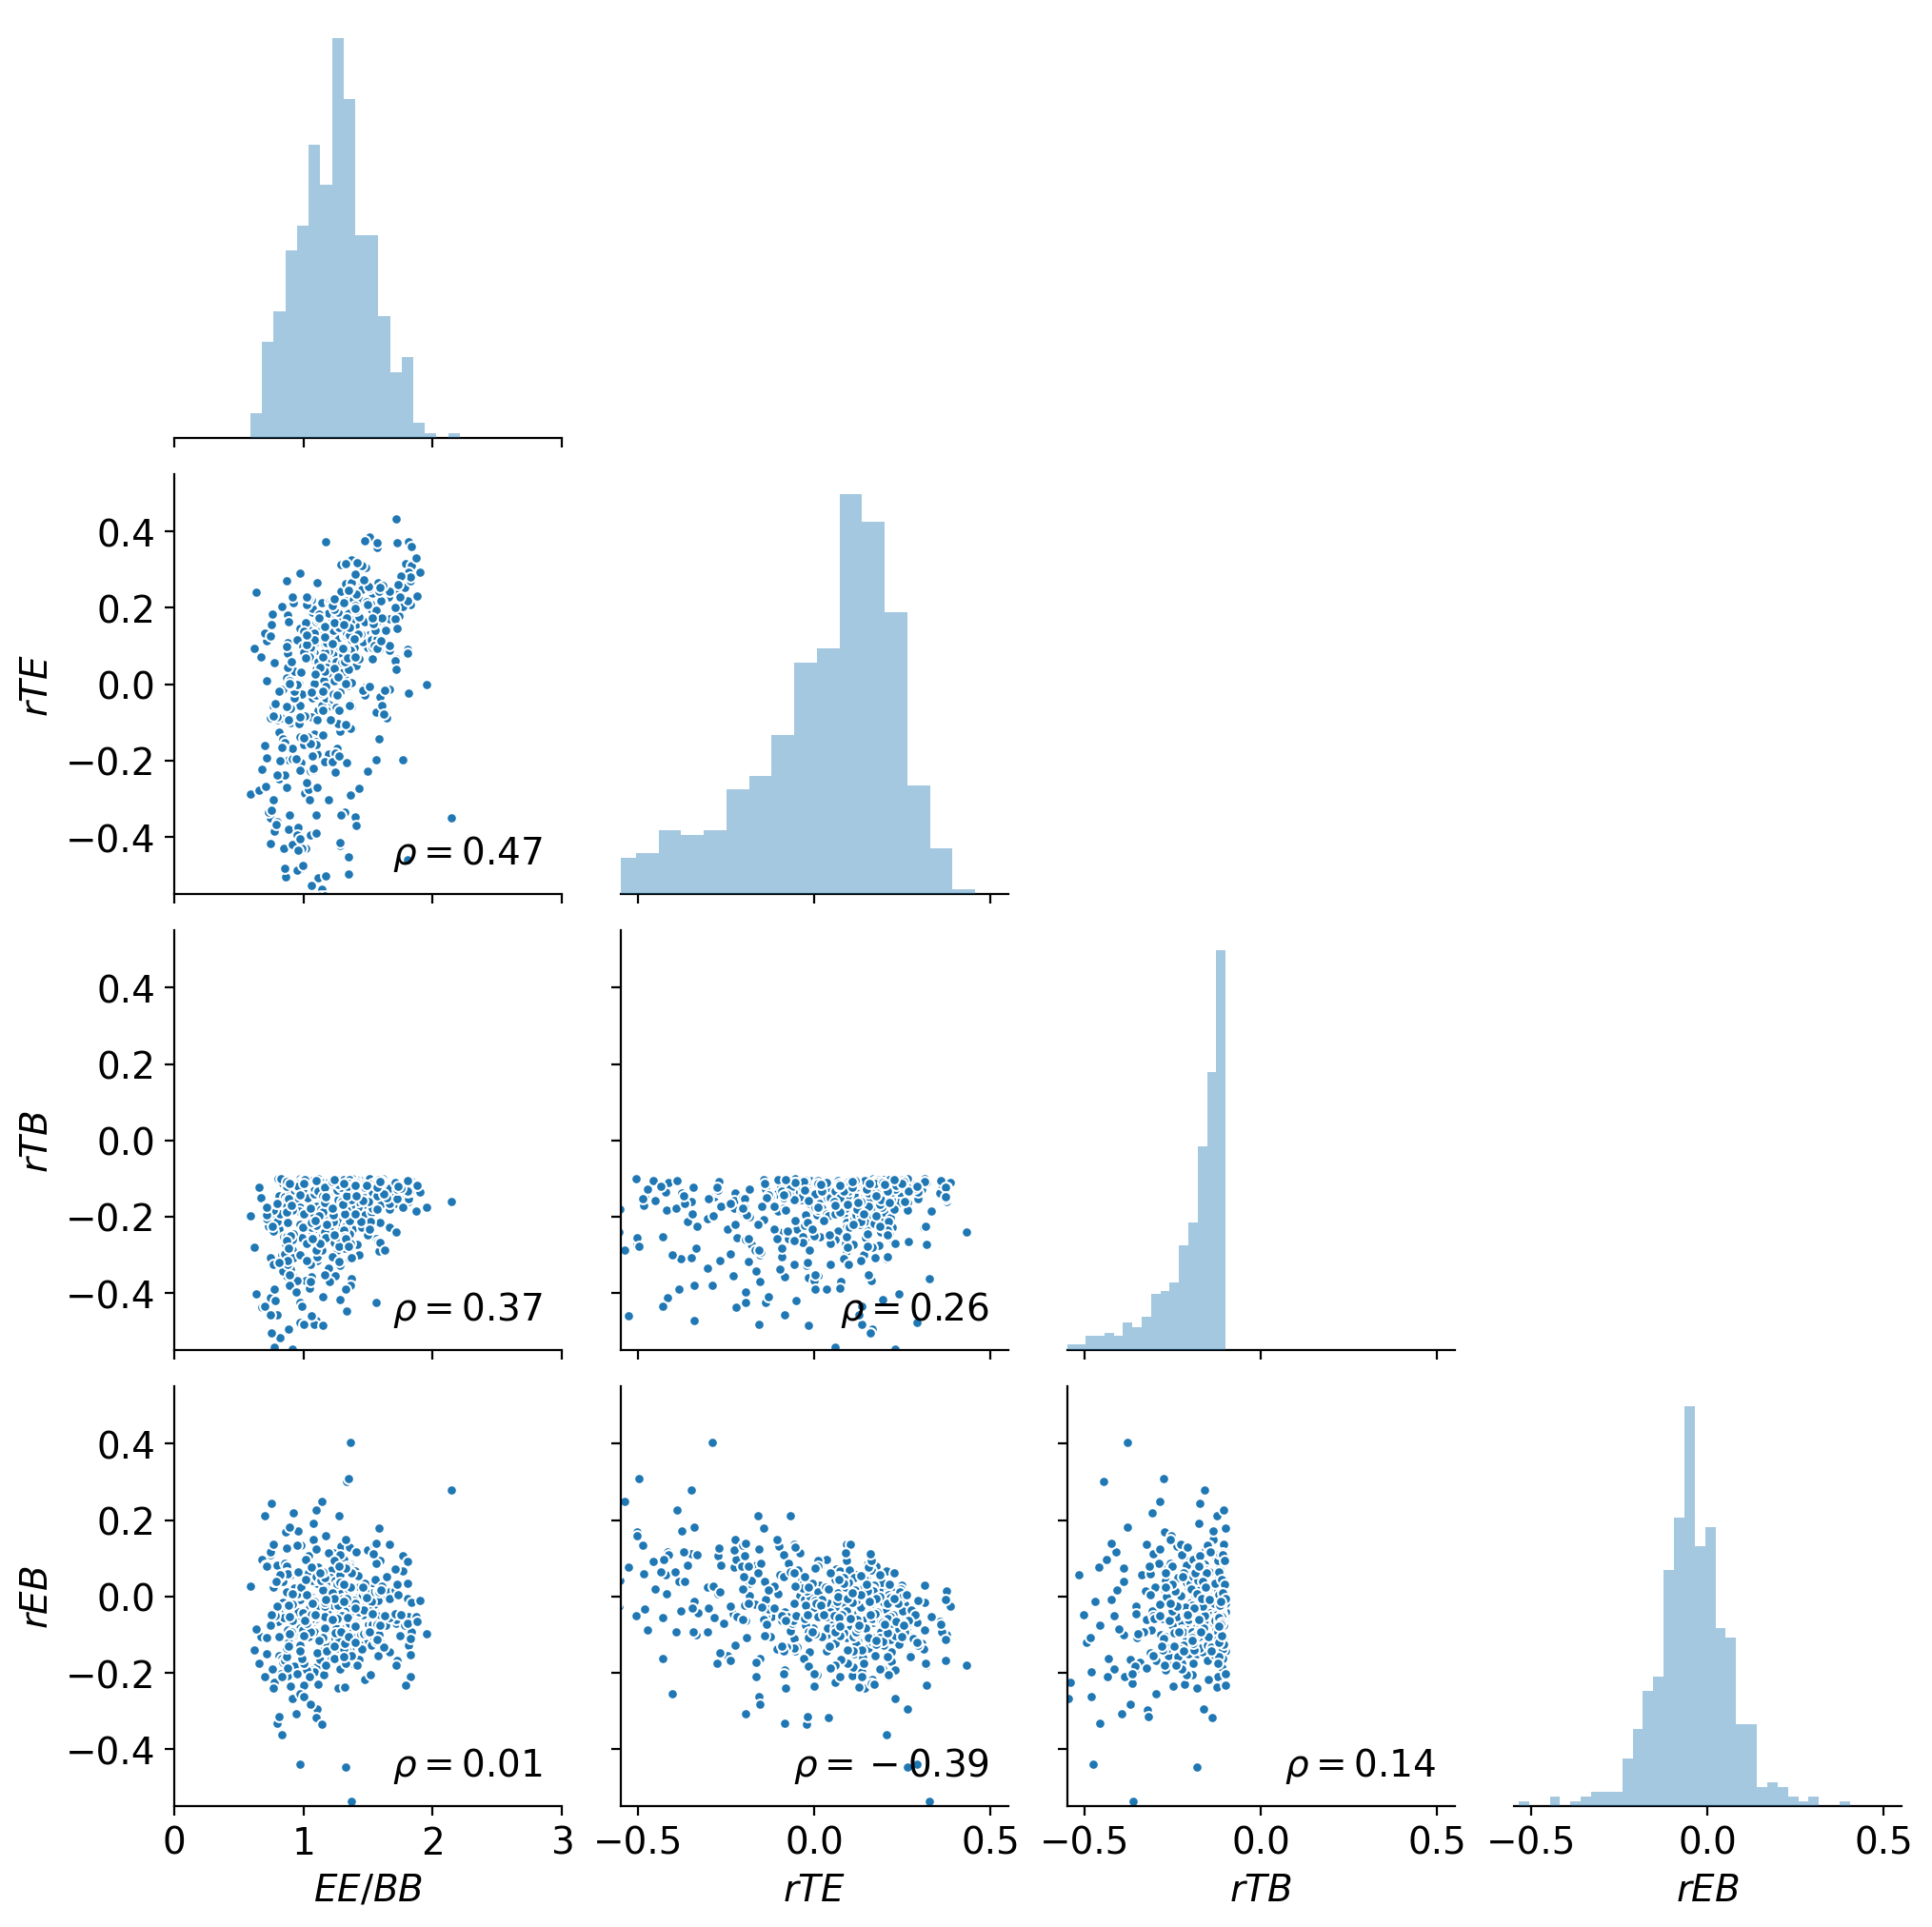

In [17]:
with plt.style.context({'figure.dpi':200,'font.size':14}):
    df_selected = df[['EEBB','rTE','rTB','rEB']].where((df.rTB<-0.1))
    g = pair_plot_with_corr(df_selected)
    g.savefig('../figures/rTBn01_all_{}.png'.format(bcut),bbox_inches='tight',dpi=200)